In [1]:
from __future__ import print_function

from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC


print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

Automatically created module for IPython interactive environment


In [2]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data # numpy array of shape (number of pictures, number of pixels per picture).  Each row corresponds to a ravelled face image.
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples (number of pictures): %d" % n_samples)
print("n_features (number of pixels per picture): %d" % n_features)
print("n_classes (number of target names): %d" % n_classes)

2017-01-01 09:52:09,082 Loading LFW people faces from C:\Users\kluna\scikit_learn_data\lfw_home


Total dataset size:
n_samples (number of pictures): 1288
n_features (number of pixels per picture): 1850
n_classes (number of target names): 7


In [3]:
# split into a training and testing set.  Random sampling to get test data.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [4]:
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled dataset): 
# unsupervised feature extraction / dimensionality reduction
n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 862 faces
done in 0.420s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.041s


In [5]:
#Train SVM Classification Model
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 19.712s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [7]:
# Quantitative evaluation of the model quality on the test set
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
done in 0.093s
                   precision    recall  f1-score   support

     Ariel Sharon       0.62      0.71      0.67        21
     Colin Powell       0.72      0.84      0.77        79
  Donald Rumsfeld       0.76      0.74      0.75        38
    George W Bush       0.88      0.85      0.86       179
Gerhard Schroeder       0.82      0.82      0.82        33
      Hugo Chavez       0.78      0.61      0.68        23
       Tony Blair       0.82      0.75      0.78        53

      avg / total       0.81      0.80      0.80       426

[[ 15   1   1   4   0   0   0]
 [  2  66   1   5   1   1   3]
 [  4   2  28   3   0   0   1]
 [  2  14   4 152   3   2   2]
 [  0   2   1   1  27   0   2]
 [  1   3   0   4   0  14   1]
 [  0   4   2   4   2   1  40]]


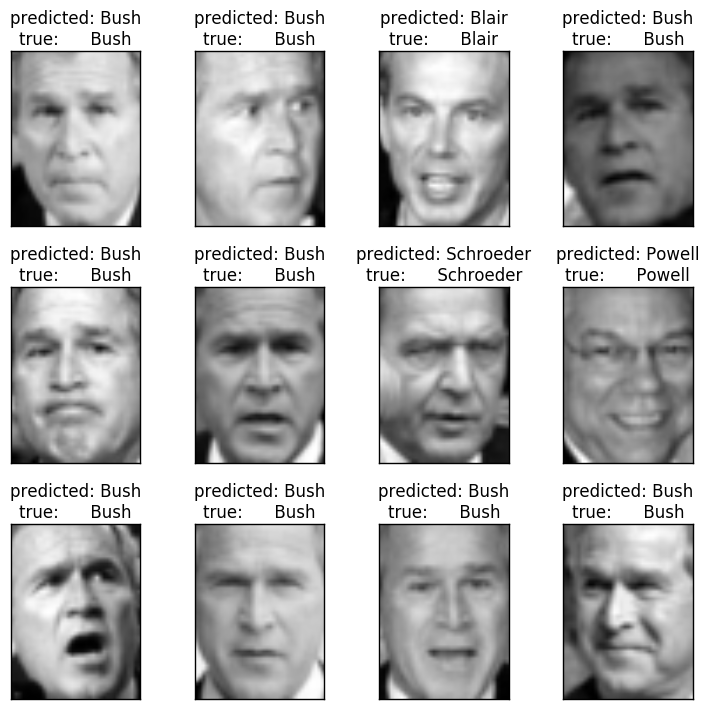

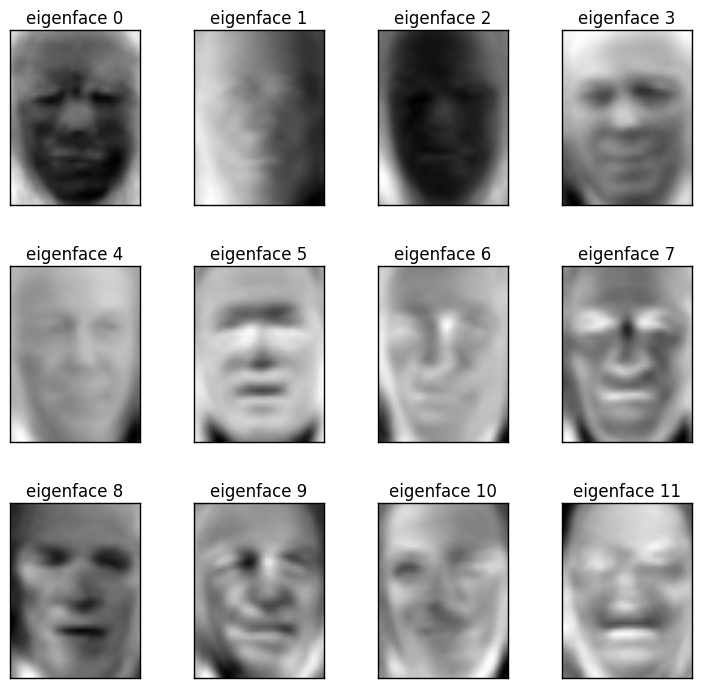

In [8]:
# Qualitative evaluation of the predictions using matplotlib
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

In [18]:
# Implement FisherFaces algorithm due to following effect of Eigenfaces method:

# "The PCA finds a linear combination of features that maximizes the total variance in data. 
# While this is clearly a powerful way to represuccsent data, it doesn’t consider any classes 
# and so a lot of discriminative information may be lost when throwing components away. 
# Imagine a situation where the variance is generated by an external source, let it be the light. 
# The components identified by a PCA do not necessarily contain any discriminative information at all, 
# so the projected samples are smeared together and a classification becomes impossible"


def fisherfaces (X ,y , num_components =0) :
    y = np.asarray(y)
    [n , d] = X.shape
    c = len (np.unique(y))
    [eigenvalues_pca , eigenvectors_pca , mu_pca] = pca (X , y , (n -c ))
    [eigenvalues_lda , eigenvectors_lda] = lda (project(eigenvectors_pca , X , mu_pca) , y ,num_components)
    eigenvectors = np.dot(eigenvectors_pca , eigenvectors_lda)
    return [ eigenvalues_lda , eigenvectors , mu_pca ]


In [19]:
# http://www.bytefish.de/pdf/facerec_python.pdf
# Note:  This is not yet finished.  I should just instead import the code from bytefish.
# For a good review of face recognition, look here:
#   Zhao, W., Chellappa, R., Phillips, P., and Rosenfeld, A. 
#   Face recognition: A literature survey. Acm Computing Surveys (CSUR) 35, 4 (2003), 399–458

import sys
# append tinyfacerec to module search path
sys.path.append("..")
# import numpy and matplotlib colormaps
import numpy as np
# import tinyfacerec modules
from tinyfacerec.subspace import fisherfaces
from tinyfacerec.util import normalize , asRowMatrix , read_images
from tinyfacerec.visual import subplot
# read images
#[X , y] = read_images ("/ home / philipp / facerec / data / yalefaces_recognition ")
# perform a full pca
[D , W , mu ] = fisherfaces(asRowMatrix (X) , y)
# import colormaps
import matplotlib.cm as cm
# turn the first (at most ) 16 eigenvectors into grayscale
# images ( note : eigenvectors are stored by column !)
E = []
for i in xrange(min(W.shape [1] , 16)):
    e = W [: , i ].reshape (X [0].shape)
    E.append(normalize (e ,0 ,255))
    # plot them and store the plot to " python_fisherfaces_fisherfaces . pdf "
    subplot(title =" Fisherfaces AT&T Facedatabase ", images =E , rows =4 , cols =4 , sptitle ="Fisherface", colormap = cm.jet , filename ="python_fisherfaces_fisherfaces.pdf")


ImportError: No module named 'tinyfacerec'

In [ ]:
from tinyfacerec . subspace import project , reconstruct
E = []
for i in xrange ( min ( W. shape [1] , 16) ):
e = W [: , i ]. reshape ( -1 ,1)
P = project (e , X [0]. reshape (1 , -1) , mu )
R = reconstruct (e , P , mu )
# reshape and append to plots
R = R . reshape ( X [0]. shape )
E. append ( normalize (R ,0 ,255) )
# plot them and store the plot to " python_reconstruction . pdf "
subplot ( title =" Fisherfaces Reconstruction Yale FDB ", images =E , rows =4 , cols =4 , sptitle
=" Fisherface ", colormap = cm . gray , filename =" python_fisherfaces_reconstruction . pdf ")